# Compare SPS and HUG

In [215]:
import numpy as np
from numpy import array, zeros, eye, sqrt, repeat, vstack, r_, log, exp
from numpy.random import rand
from numpy.linalg import norm
from scipy.stats import multivariate_normal as MVN
from scipy.stats import multivariate_t as MVT
from scipy.optimize import fsolve

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf

from RWM import RWM
from tangential_hug_functions import Hug

In [36]:
d  = 100                      # Dimension of the Sphere. Ambient space is R^{d+1}
R  = sqrt(d)                  # Parameter
N  = 5000                     # Number of samples

In [138]:
def generate_north_pole(d):
    """Generates d-dimensional North Pole."""
    north_pole     = zeros(d + 1)
    north_pole[-1] = 1
    return north_pole

def generate_south_pole(d):
    """Generates d-dimensional South Pole."""
    south_pole    = zeros(d + 1)
    south_pole[0] = 1
    return south_pole

def sp(z, R=R):
    """Takes a point z on the d-dimensional sphere with ambient space R^{d+1}, and maps it to R^d."""
    return R * (z[:-1] / (1 - z[-1]))

def Jsp(x, R=R):
    """Jacobian of Stereographic Projection."""
    return (R**2 + x@x)**(len(x))

def sp_inv(x, R=R):
    """Inverse Stereographic Projection."""
    return r_[2*R*x / (x@x + R**2), (x@x - R**2) / (x@x + R**2)]

def πsp(x, R=R):
    """Transformed density. Density on Sphere."""
    return π(x) * Jsp(x, R=R)

def SPS(x, h, R=R):
    """Stereographic Projection Sampler."""
    d  = len(x) 
    z  = sp_inv(x, R=R)
    dz = MVN(zeros(d+1), (h**2)*eye(d+1)).rvs()
    dz - (z @ dz)*z/(z@z)
    ẑ  = (z + dz)
    ẑ /= sqrt(ẑ @ ẑ)
    x̂  = sp(ẑ, R=R)
    loga = min(0, logπ(x̂) + d*log(R**2 + x̂@x̂) - logπ(x) - d*log(R**2 + x@x))
    logu  = log(rand())
    if logu <= loga:
        return x̂, 1
    else:
        return x, 0
    
def SPS_sampler(x, N, h, R=R):
    """SPS sampler."""
    samples = x
    acceptances = zeros(N)
    for i in range(N):
        new_sample, flag = SPS(x, h=h, R=R)
        samples = vstack((samples, new_sample))
        acceptances[i] = flag
    return samples[1:], acceptances

#### Gaussian Example

In [186]:
π = MVN(zeros(d), eye(d)).pdf        # Standard Gaussian Target in 100 dimensions
logπ = MVN(zeros(d), eye(d)).logpdf

In [166]:
# SPS starts from north pole
h = 1.0
north_pole = generate_north_pole(d)
south_pole = generate_south_pole(d)
x_south_pole = sp(south_pole)
# start from a random point on the sphere
random_point_on_sphere = MVN(zeros(d+1), eye(d+1)).rvs()
random_point_on_sphere /= norm(random_point_on_sphere)
random_point_rn = sp(random_point_on_sphere)
s_sps, a_sps = SPS_sampler(random_point_rn, N, h=h, R=R)

In [84]:
# RWM starts from different but all of the form (c, ..., c) for c=10,20,50
c = 10
rwm_start = repeat(c, d)
rwm_scale = 0.0739
s_rwm_10, a_rwm_10 = RWM(rwm_start, rwm_scale, N, logπ)

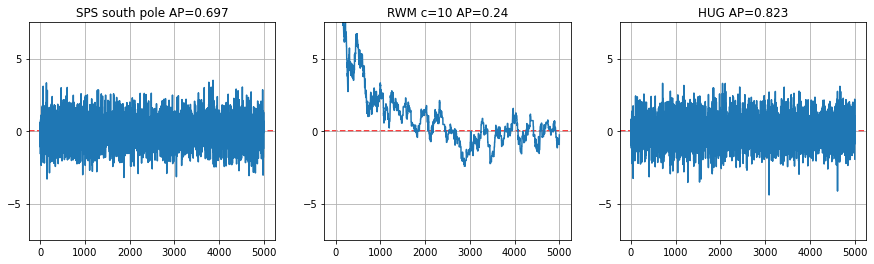

In [222]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
# SPS
ax[0].plot(s_sps[:, 0])
ax[0].axhline(y=0.0, color='red', ls='--', zorder=-10)
ax[0].set_title("SPS south pole AP={:.3}".format(a_sps.mean()))
ax[0].set_yticks([-5, 0, 5])
ax[0].set_ylim([-7.5, 7.5])
ax[0].grid()
# RWM
ax[1].plot(s_rwm_10[:, 0])
ax[1].axhline(y=0.0, color='red', ls='--', zorder=-10)
ax[1].set_title("RWM c={} AP={:.3}".format(c, a_rwm_10.mean()))
ax[1].set_yticks([-5, 0, 5])
ax[1].set_ylim([-7.5, 7.5])
ax[1].grid()
# Hug
ax[2].plot(shug[:, 0])
ax[2].axhline(y=0.0, color='red', ls='--', zorder=-10)
ax[2].set_title("HUG AP={:.3}".format(ahug.mean()))
ax[2].set_yticks([-5, 0, 5])
ax[2].set_ylim([-7.5, 7.5])
ax[2].grid()
plt.show()

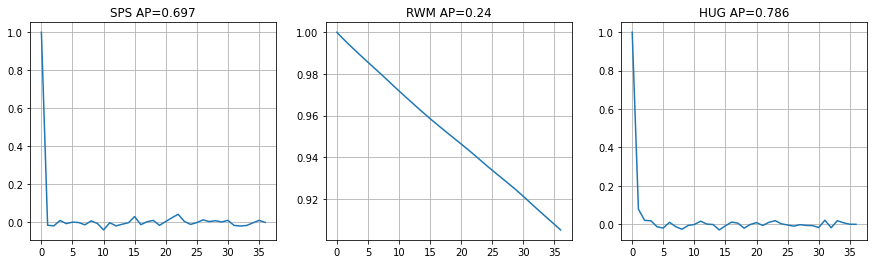

In [233]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))
acfs = [acf(s_sps[:, 0]), acf(s_rwm_10[:, 0]), acf(shug[:, 0])]
algs = ["SPS", "RWM", "HUG"]
accept_probs = [a_sps.mean(), a_rwm_10.mean(), ahug.mean()]
titles = ["{} AP={:.3}".format(alg, ap) for alg, ap in zip(algs, accept_probs)]
for i in range(3):
    ax[i].plot(acfs[i])
    ax[i].set_title(titles[i])
    ax[i].grid()
plt.show()

In [ ]:
# Try using HUG 
def sp_hug_sampler(x, N, h, R=R):
    """SP + HUG."""
    samples = x
    acceptances = zeros(N)
    for i in range(N):
        new_sample, flag
    pass

In [ ]:
def SPS_sampler(x, N, h, R=R):
    """SPS sampler."""
    samples = x
    acceptances = zeros(N)
    for i in range(N):
        new_sample, flag = SPS(x, h=h, R=R)
        samples = vstack((samples, new_sample))
        acceptances[i] = flag
    return samples[1:], acceptances

In [196]:
q = MVN(zeros(d+1), eye(d+1))
grad_function = lambda z: -z
def logπ_sphere(z):
    x = sp(z)
    return logπ(x) + d*log(R**2 + x@x)

In [206]:
def HugMechanics(x, q, T, B, logpi, grad_log_pi):
    v = q.rvs()
    δ = T / B
    for _ in range(B):
        x = x + δ*v/2                             ## Move
        g = grad_log_pi(x); ghat = g / norm(g)    ## Reflect
        v = v - 2*(v @ ghat) * ghat
        x = x + δ*v/2                             ## Move
    return x

In [207]:
def sps_hug(x, N, T=1, B=5, R=R):
    """Basically we want to do the same thing just using Hug instead of their weird sampler."""
    d = len(x)
    q = MVN(zeros(d+1), eye(d+1))
    ### density on sphere
    def logπ_sphere(z):
        x = sp(z)
        return logπ(x) + d*log(R**2 + x@x)
    grad_function = lambda z: -z
    ### store shit
    samples = x
    acceptances = zeros(N)
    ### iterate
    for i in range(N):
        z = sp_inv(x)
        z_new = HugMechanics(z, q, T, B, logπ_sphere, grad_function)
        x_new = sp(z_new)
        # Accept-Rejevct step
        loga = min(0, logπ(x_new) + d*log(R**2 + x_new@x_new) - logπ(x) - d*log(R**2 + x@x))
        logu  = log(rand())
        if logu <= loga:
            samples = vstack((samples, x_new))
            acceptances[i] = 1
            x = x_new
        else:
            samples = vstack((samples, x))
            acceptances[i] = 0
    return samples[1:], acceptances

In [232]:
shug, ahug = sps_hug(random_point_rn, N, T=7)

#### Student-t Example